# T2 - basic simulation

The purpose of this tutorial is to show you to use `pyvd` to create basic simulations of population dynamics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvd
print(f"pyvd version: {pyvd.__version__}")

pyvd version: 0.4.5


We will use the mortality and birth rates for India (see T1 tutorial):

In [2]:
pop_input = pyvd.make_pop_dat('IND') # 22 x 31 matrix
# year vector
year_vec = pop_input[0, :] - pyvd.constants.BASE_YEAR
# first year (0)
year_init = pyvd.constants.BASE_YEAR - pyvd.constants.BASE_YEAR
# array of ages used for the mortality and population
mort_age_vec = np.array(pyvd.constants.MORT_XVAL)
# population matrix (add small value to avoid zeros): age x year
pop_mat = pop_input[1:, :] + 0.1
pop_init = [np.interp(year_init, year_vec, pop_mat[idx, :])
            for idx in range(pop_mat.shape[0])]
# calculate vital dynamics
vd = pyvd.demog_vd_calc(year_vec, year_init, pop_mat, pop_init)

Next we capture the aging, births, and deaths in a function. Not that we are going to be using years as our time unit so have to do some conversions of the birth and mortality rates which are daily.

In [3]:
def sim(pop_by_age,t,vd,age_bin_edges):    
    # aging
    age_rate = 1./np.diff(age_bin_edges)
    dpdt = np.concatenate(([-age_rate[0]*pop_by_age[0]],  age_rate[:-1]*pop_by_age[:-1]-age_rate[1:]*pop_by_age[1:]))
    # births (pyvd birth rate is per person per day)
    dpdt[0] += (np.exp(365*vd.birth_rate*np.interp(t, vd.br_mult_x/365, vd.br_mult_y)) - 1 )*np.sum(pop_by_age)
    # deaths (death rate is per person per day)
    dpdt -= pop_by_age * (np.exp(365*np.array([np.interp(t, vd.mort_year, vd.mort_mat[2*i,:]) for i in range(vd.mort_mat.shape[0]//2)])) - 1)
    return dpdt.tolist()

We will use scipy's odeint to solve the equation

In [4]:
from scipy.integrate import odeint
# run the integration
p0 = np.array(pop_init)
t = year_vec
age_bin_edges = np.concat((pyvd.constants.MORT_XVAL[::2], [pyvd.constants.MORT_XVAL[-1]])) / 365
sol = odeint(sim, p0, t, args=(vd, age_bin_edges))

and plot the results:

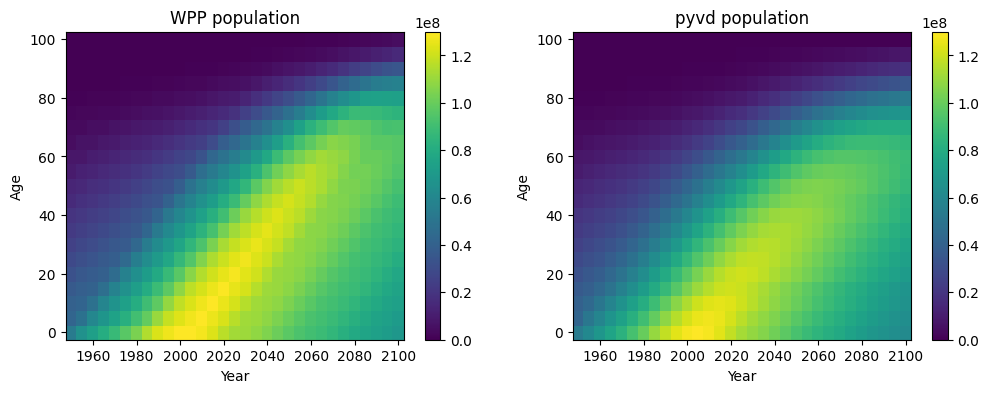

In [5]:
mort_age_vec = np.array(pyvd.constants.MORT_XVAL)
kwargs = {'vmin':0, 'vmax':1.3e8}
fig,axes = plt.subplots(1,2, figsize=(12,4))
c = axes[0].pcolor(pyvd.constants.BASE_YEAR + year_vec, mort_age_vec[::2]/365, pop_mat, **kwargs)
plt.colorbar(c)
c = axes[1].pcolor(pyvd.constants.BASE_YEAR + year_vec, mort_age_vec[::2]/365, sol.T, **kwargs)
plt.colorbar(c)
for i, ax in enumerate(axes):
    ax.set_xlabel('Year')
    ax.set_ylabel('Age')
    ax.set_title('WPP population'if i == 0 else 'pyvd population')